# Build an ARMA Predictive Time Series Model for Larcenies

import python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from math import sqrt

set figure size

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Section 0: Load the data and clean

read the raw data set from CSV file

In [3]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [4]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


In [5]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [6]:
df.index = df['incident_dt']

# Section 1: Larceny theft over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [7]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [8]:
larceny_incidents['incident_dt'].count()

27657

lets roll up the events up by month and study the pattern over time

In [65]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [68]:
X = larceny_monthly_counts.rename('lar_cnts')

In [69]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: lar_cnts, dtype: float64

In [70]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: lar_cnts, dtype: int64

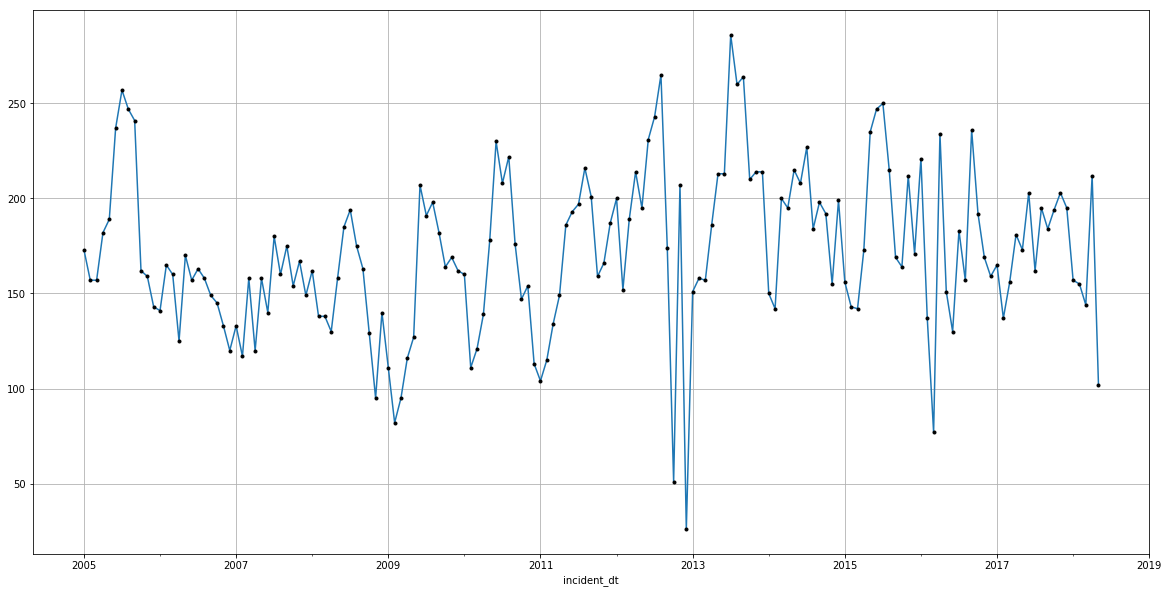

In [72]:
X.plot()
X.plot(style='k.', grid=True)

## Section 1.1 Modeling the data with a time series analysis

lets build an AR model

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

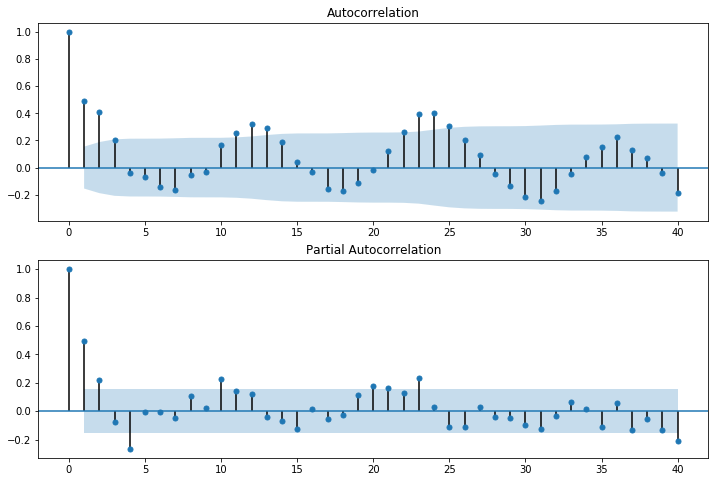

In [73]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=40, ax=ax2)

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

In [74]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


In [154]:
arma_mod = sm.tsa.ARMA(X, (13,1)).fit(disp=False)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

1611.3347141881493 1663.718588392885 1632.6046950764487


In [155]:
predicted = arma_mod.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
print(compare)

             actual   predicted
incident_dt                    
2017-07-31      162  195.257631
2017-08-31      195  194.974376
2017-09-30      184  205.563846
2017-10-31      194  184.134434
2017-11-30      203  180.721142
2017-12-31      195  170.535142
2018-01-31      157  158.159635
2018-02-28      155  160.125281
2018-03-31      144  159.469819
2018-04-30      212  167.739489


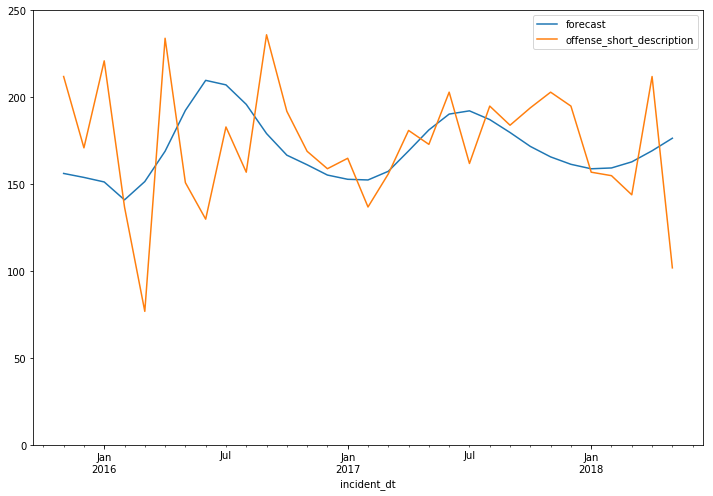

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
plt.ylim(0, 250)
fig = arma_mod20.plot_predict(130, 160, dynamic=True, ax=ax, plot_insample=True)

In [157]:
train_size = 100
predict_size = 10
train, test = X[0:train_size], X[train_size:train_size + predict_size]
predicted = arma_mod.predict(train_size, train_size + predict_size, dynamic=True)

In [158]:
train.head(10)

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
2005-06-30    237
2005-07-31    257
2005-08-31    247
2005-09-30    241
2005-10-31    162
Freq: M, Name: lar_cnts, dtype: int64

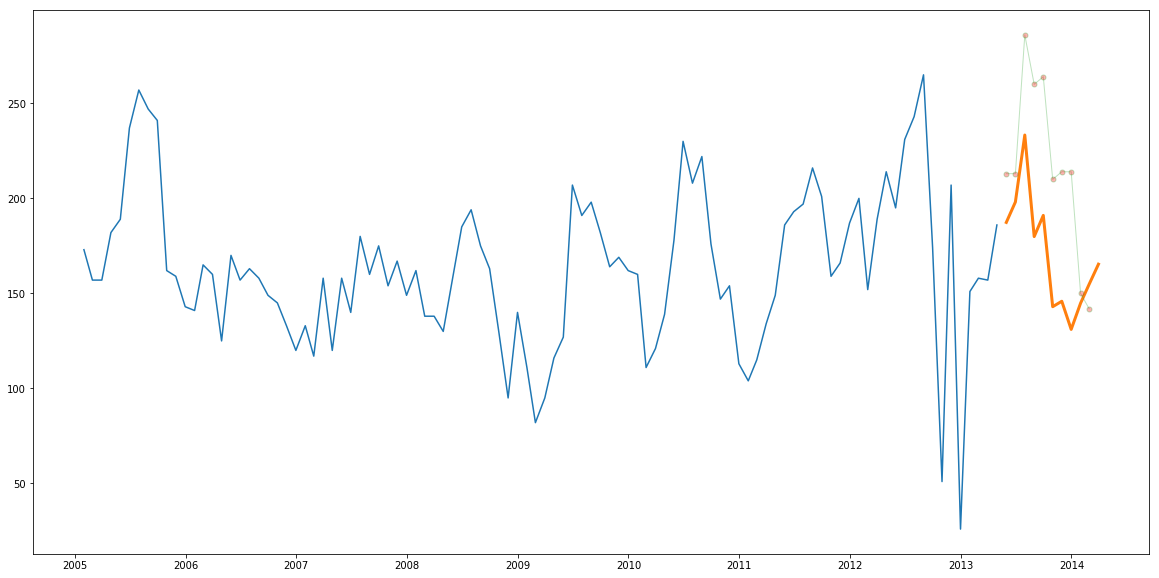

In [159]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')